<a href="https://colab.research.google.com/github/NikhitapHegde/final_year_project/blob/main/Copy_of_Copy_of_Untitled3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam

In [ ]:
# NOISE_DIM = 100
# BATCH_SIZE = 4
# STEPS_PER_EPOCH = 3750
# EPOCHS = 10
# SEED = 40
# WIDTH, HEIGHT, CHANNELS = 128, 128, 1

# OPTIMIZER = Adam(0.0002, 0.5)

NOISE_DIM = 100
BATCH_SIZE = 6   # Increase slightly from 4 to 8
STEPS_PER_EPOCH = 100  # Adjust based on dataset size
EPOCHS = 20  # Keep the same, increase to 20-30 if needed
SEED = 40  # No change
WIDTH, HEIGHT, CHANNELS = 128, 128, 1  # No change
OPTIMIZER = Adam(0.0002, 0.5)  # No change

In [ ]:
from google.colab import files

# Upload the ZIP file
uploaded = files.upload()

Saving archive (1).zip to archive (1).zip


In [ ]:
import zipfile
import os

# Define the name of the uploaded ZIP file
zip_file_name = 'archive (1).zip'  # Change this if your file has a different name

# Extract the ZIP file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

print("Files extracted to: extracted_files/")

Files extracted to: extracted_files/


In [ ]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from tqdm import tqdm

manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
dataroot ='extracted_files/brain_tumor_dataset'

workers = 2
batch_size = 64
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 2500
lr = 0.0002
beta1 = 0.5
ngpu = 1

Random Seed:  999


dataloader:  <enumerate object at 0x7e888e383580>


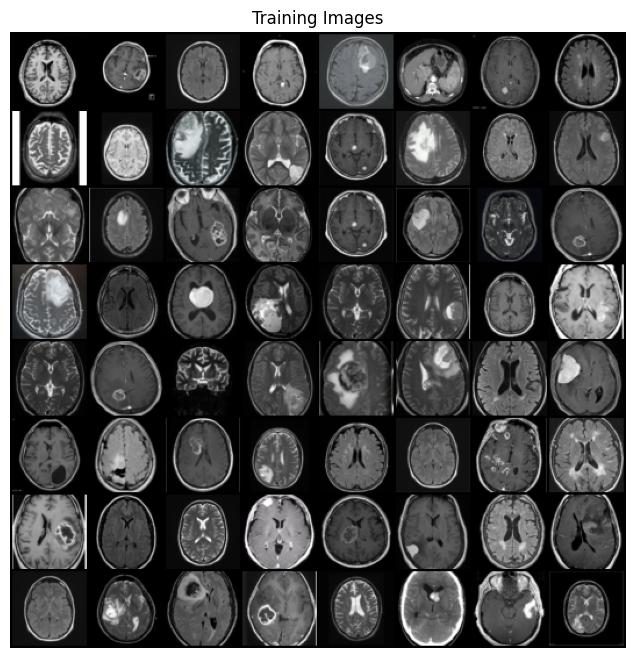

In [ ]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
print("dataloader: ", enumerate(dataloader))

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()

        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
dataroot = "/kaggle/input/brain-mri-images-for-brain-tumor-detection"

workers = 2
batch_size = 64
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 3000
lr = 0.0002
beta1 = 0.5
ngpu = 1
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        iters += 1

        if iters % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (epoch == 300):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            output_path = '/extracted_files/DCGAN_results_epoch_300/'
            if not os.path.exists(output_path):
                os.makedirs(output_path)

            for i in range(64):
                vutils.save_image(fake[i], '%s/fake_samples_epoch_300_%d.png' %
                                  (output_path, i), normalize=True)

Starting Training Loop...
[12/3000][1/4]	Loss_D: 0.1260	Loss_G: 6.3472	D(x): 0.9392	D(G(z)): 0.0480 / 0.0030
[24/3000][3/4]	Loss_D: 0.0085	Loss_G: 18.6609	D(x): 0.9918	D(G(z)): 0.0000 / 0.0000
[37/3000][1/4]	Loss_D: 0.6954	Loss_G: 19.9350	D(x): 0.9934	D(G(z)): 0.4061 / 0.0000
[49/3000][3/4]	Loss_D: 0.2585	Loss_G: 6.6108	D(x): 0.8930	D(G(z)): 0.0984 / 0.0024
[62/3000][1/4]	Loss_D: 0.1698	Loss_G: 23.3892	D(x): 0.9002	D(G(z)): 0.0000 / 0.0000
[74/3000][3/4]	Loss_D: 0.1325	Loss_G: 11.9589	D(x): 0.8957	D(G(z)): 0.0003 / 0.0000
[87/3000][1/4]	Loss_D: 0.2679	Loss_G: 8.8782	D(x): 0.8122	D(G(z)): 0.0004 / 0.0004
[99/3000][3/4]	Loss_D: 0.1318	Loss_G: 9.5659	D(x): 0.9938	D(G(z)): 0.1136 / 0.0002
[112/3000][1/4]	Loss_D: 0.6867	Loss_G: 8.7045	D(x): 0.6429	D(G(z)): 0.0001 / 0.0017
[124/3000][3/4]	Loss_D: 0.0815	Loss_G: 8.7531	D(x): 0.9540	D(G(z)): 0.0050 / 0.0005
[137/3000][1/4]	Loss_D: 0.1303	Loss_G: 6.1705	D(x): 0.9516	D(G(z)): 0.0680 / 0.0032
[149/3000][3/4]	Loss_D: 0.7826	Loss_G: 19.2511	D(x): 0

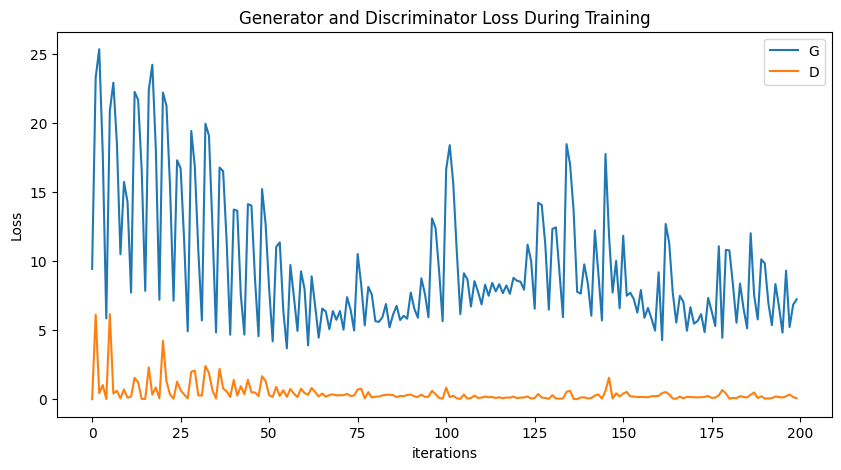

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

IndexError: list index out of range

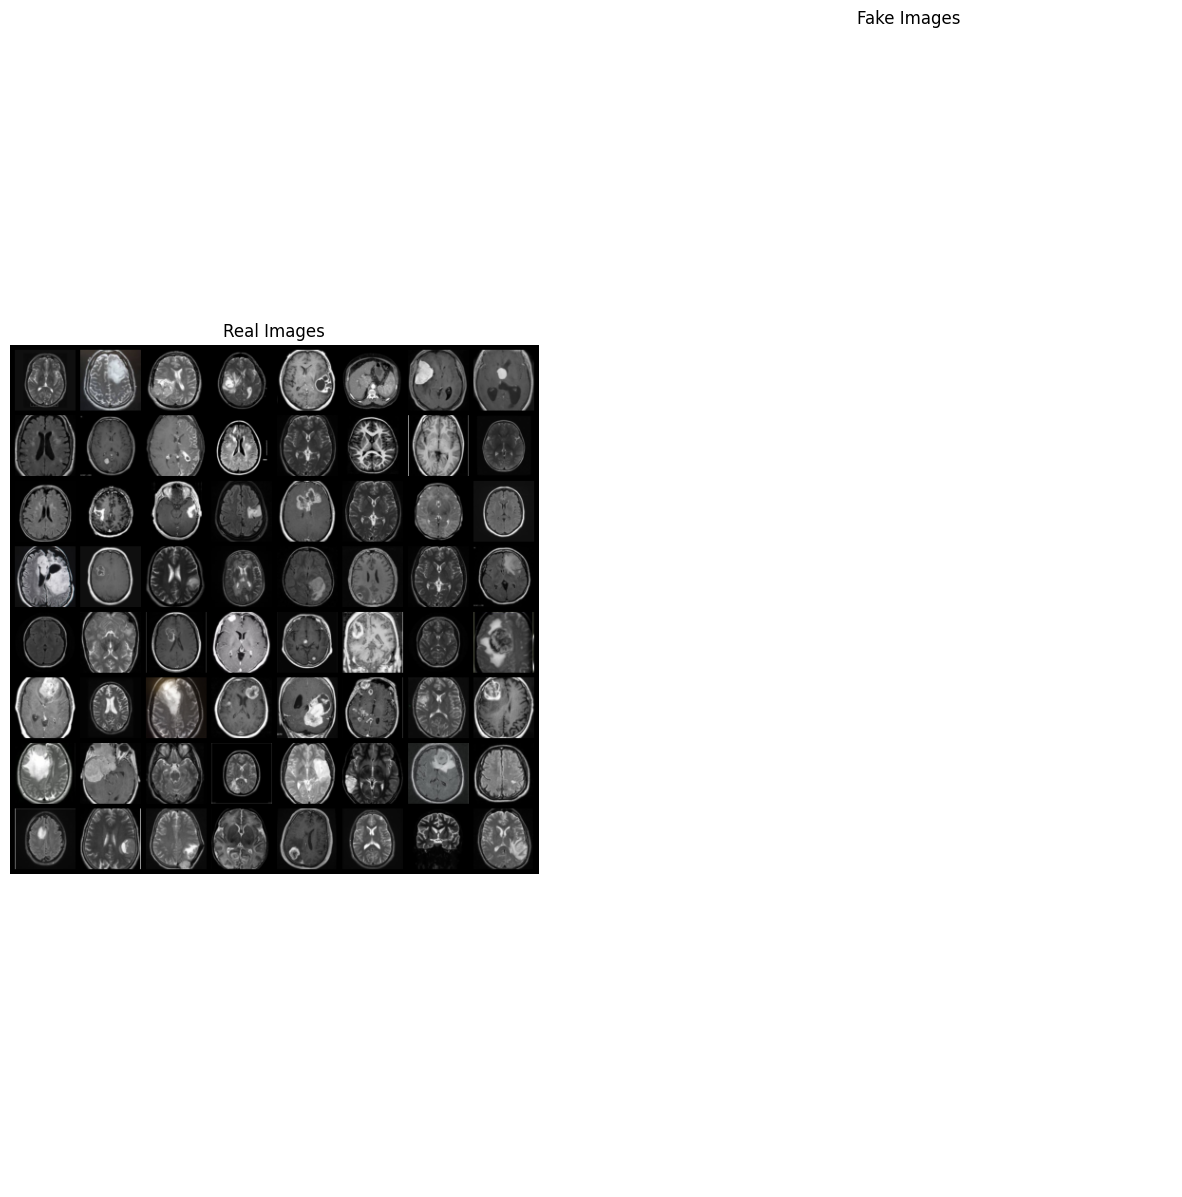

In [ ]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
import torch
import torch.utils.data as data
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import os
from torchvision import datasets
from torchvision.utils import save_image

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters for both models
batch_size = 64
image_size = 64
nz = 100
num_epochs = 3000  # Training for 3000 epochs
lr = 0.0002
beta1 = 0.5

# Define the Generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Define the Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Create the models for Tumor and Non-Tumor
netG_tumor = Generator().to(device)
netD_tumor = Discriminator().to(device)

netG_non_tumor = Generator().to(device)
netD_non_tumor = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizerD_tumor = optim.Adam(netD_tumor.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG_tumor = optim.Adam(netG_tumor.parameters(), lr=lr, betas=(beta1, 0.999))

optimizerD_non_tumor = optim.Adam(netD_non_tumor.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG_non_tumor = optim.Adam(netG_non_tumor.parameters(), lr=lr, betas=(beta1, 0.999))

# Load the tumor and non-tumor datasets
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

dataroot = "extracted_files/brain_tumor_dataset"
dataset_tumor = datasets.ImageFolder(root=dataroot + '/yes', transform=transform)
dataset_non_tumor = datasets.ImageFolder(root=dataroot + '/no', transform=transform)

dataloader_tumor = data.DataLoader(dataset_tumor, batch_size=batch_size, shuffle=True, num_workers=2)
dataloader_non_tumor = data.DataLoader(dataset_non_tumor, batch_size=batch_size, shuffle=True, num_workers=2)

# Function to train the models and generate images during the training process
def train_and_generate_images(model, dataloader, epoch, fixed_noise, directory):
    generated_images = 0
    for i, data in enumerate(dataloader, 0):
        if generated_images >= num_images:
            break

        # Update Discriminator
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)  # Real labels
        output = model[1](real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = model[0](noise)
        label.fill_(0)  # Fake labels
        output = model[1](fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        errD = errD_real + errD_fake
        model[2].step()

        # Update Generator
        model[0].zero_grad()
        label.fill_(1)  # Real labels
        output = model[1](fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        model[3].step()

        generated_images += b_size

        # Save images after each batch if we have generated enough
        if generated_images % 64 == 0:
            save_image(fake, f'{directory}/fake_samples_epoch_{epoch}_batch_{i}.png', normalize=True)

    print(f"Generated {generated_images} images so far")

# Train Tumor Model for 3000 epochs
print("Starting Training Loop for Tumor Images...")
for epoch in range(num_epochs):
    train_and_generate_images([netG_tumor, netD_tumor, optimizerD_tumor, optimizerG_tumor], dataloader_tumor, epoch, None, "extracted_files/brain_tumor_dataset/yes")

# Train Non-Tumor Model for 3000 epochs
print("Starting Training Loop for Non-Tumor Images...")
for epoch in range(num_epochs):
    train_and_generate_images([netG_non_tumor, netD_non_tumor, optimizerD_non_tumor, optimizerG_non_tumor], dataloader_non_tumor, epoch, None, "extracted_files/brain_tumor_dataset/no")

# Function to generate extra images using the trained models
def generate_extra_images(model, num_images, directory):
    model.eval()  # Set the model to evaluation mode
    noise = torch.randn(num_images, nz, 1, 1, device=device)  # Generate random noise
    fake_images = model(noise)  # Generate fake images from the noise
    save_image(fake_images, f'{directory}/extra_fake_samples.png', normalize=True)  # Save the generated images

# Generate extra images for Tumor dataset
tumor_directory = "extracted_files/brain_tumor_dataset/yes"  # Path for Tumor images
generate_extra_images(netG_tumor, num_images=1500, directory=tumor_directory)

# Generate extra images for Non-Tumor dataset
non_tumor_directory = "extracted_files/brain_tumor_dataset/no"  # Path for Non-Tumor images
generate_extra_images(netG_non_tumor, num_images=1500, directory=non_tumor_directory)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import os
import numpy as np
from PIL import Image
from torchvision.utils import save_image
import matplotlib.pyplot as plt

# Directory paths for training data
non_tumor_dir = "extracted_files/brain_tumor_dataset/no"  # Directory for non-tumor images
tumor_dir = "extracted_files/brain_tumor_dataset/yes"  # Directory for tumor images

# Directories for generated images
non_tumor_output_dir = "extracted_files/brain_tumor_dataset/no"
tumor_output_dir = "extracted_files/brain_tumor_dataset/yes"

# Ensure output directories exist
os.makedirs(non_tumor_output_dir, exist_ok=True)
os.makedirs(tumor_output_dir, exist_ok=True)

# Image preprocessing (resize and normalize)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Dataset loading for real images (non-tumor and tumor)
non_tumor_dataset = datasets.ImageFolder(root=non_tumor_dir, transform=transform)
tumor_dataset = datasets.ImageFolder(root=tumor_dir, transform=transform)

# Combine the datasets
all_data = non_tumor_dataset + tumor_dataset

# Create DataLoader for loading batches of data
data_loader = torch.utils.data.DataLoader(all_data, batch_size=64, shuffle=True)

# Define the Generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3 * 64 * 64),
            nn.Tanh()
        )

    def forward(self, z):
        z = self.fc(z)
        z = z.view(z.size(0), 3, 64, 64)
        return z

# Define the Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(3 * 64 * 64, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Initialize the Generator and Discriminator
generator = Generator().cuda()
discriminator = Discriminator().cuda()

# Set up the optimizer and loss function
criterion = nn.BCELoss()
lr = 0.0002
beta1 = 0.5
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Labels for the Generator and Discriminator
real_label = 1
fake_label = 0

# Training loop
num_epochs = 50
z_dim = 100  # Latent vector size
fixed_noise = torch.randn(64, z_dim).cuda()  # Generate fixed noise for monitoring progress

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(data_loader):
        batch_size = real_images.size(0)
        real_images = real_images.cuda()

        # Generate labels for real images
        labels = torch.full((batch_size,), real_label, dtype=torch.float).cuda()

        # Train Discriminator
        optimizer_D.zero_grad()
        output = discriminator(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()

        noise = torch.randn(batch_size, z_dim).cuda()
        fake_images = generator(noise)
        labels.fill_(fake_label)

        output = discriminator(fake_images.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()

        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        labels.fill_(real_label)
        output = discriminator(fake_images)
        errG = criterion(output, labels)
        errG.backward()

        optimizer_G.step()

        # Print training progress
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(data_loader)}], "
                  f"ErrD: {errD_real.item() + errD_fake.item():.4f}, ErrG: {errG.item():.4f}")

    # Save generated images every epoch
    with torch.no_grad():
        fake_images = generator(fixed_noise).detach().cpu()
        save_image(fake_images, f'generated_images_epoch_{epoch}.jpg', nrow=8, normalize=True)

    # Save the generated images in the respective directories
    if epoch % 5 == 0:
        # Generate images for non-tumor and tumor categories
        non_tumor_images = generator(torch.randn(1500, z_dim).cuda()).detach().cpu()
        tumor_images = generator(torch.randn(1500, z_dim).cuda()).detach().cpu()

        # Save non-tumor images
        for idx, img in enumerate(non_tumor_images):
            img_path = os.path.join(non_tumor_output_dir, f"non_tumor_{epoch}_{idx}.jpg")
            save_image(img, img_path, normalize=True)

        # Save tumor images
        for idx, img in enumerate(tumor_images):
            img_path = os.path.join(tumor_output_dir, f"tumor_{epoch}_{idx}.jpg")
            save_image(img, img_path, normalize=True)

    # Optionally visualize some of the generated images
    if epoch % 10 == 0:
        plt.figure(figsize=(8, 8))
        plt.imshow(np.transpose(fake_images[0], (1, 2, 0)))
        plt.show()


FileNotFoundError: Couldn't find any class folder in extracted_files/brain_tumor_dataset/no.